In [1]:
using PyPlot
include("../saltsolver.jl")
include("../passive.jl")

function mirrorflip(E)
    Eaug = [E[end]; E]
    flipdim(Eaug,1)[2:end]
end

function coefs(f, Es)
    dot(Es[1], f)/norm(Es[1])^2, dot(Es[2], f)/norm(Es[2])^2
end

function quad_newton(A, B, C, σ, x, its=20, tol=1e-8)
    N = size(A, 1)
    J = zeros(Complex{Float64}, N+1, N+1)
    f = zeros(Complex{Float64}, N+1)
    dv = zeros(Complex{Float64}, N+1)
    for i = 1:its
        x += dv[1:N]
        x = x / norm(x)
        σ += dv[end]
        J[1:N, 1:N] = A + σ*B + σ^2 * C
        f[1:N] = J[1:N, 1:N] * x
        #println("|f| = ", norm(f))
        if norm(f) < tol
            break
        end
        J[1:N, end] = B*x + 2*σ*(C*x)
        J[end, 1:N] = x'
        dv = -(J \ f)
    end
    σ, x
end

/Users/davidliu/.julia/v0.4/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


quad_newton (generic function with 3 methods)

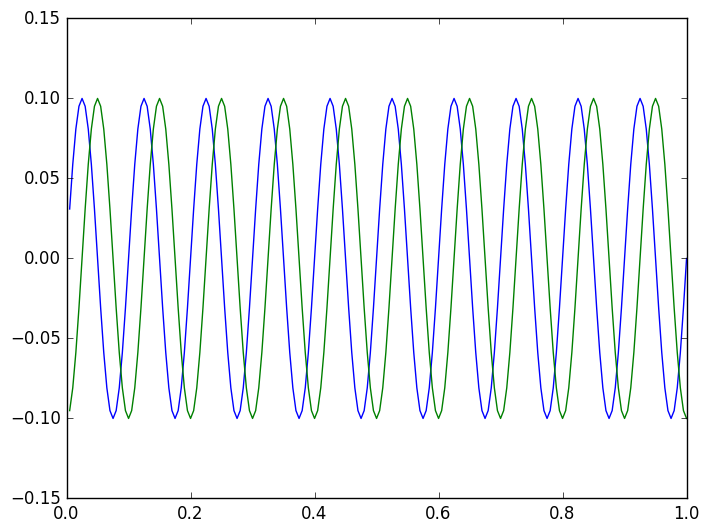

2-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31d3c8c10>
 PyObject <matplotlib.lines.Line2D object at 0x31d3c8e10>

In [2]:
# this is a test of the unstable circulating mode in Rotter/Burkhardt, Fig. 1
N = 200
L = 1.0
h = L/N
x = linspace(h, L, N)
F = ones(N)
M = zeros(N, N)
laplacian!(J) = periodic!(J, h)
laplacian!(M)
Λ, X = eig(M)
reverse!(Λ)
X = X[:, reverse(1:N)]
ωs = √abs(Λ);
ieig = 20
ω = ωs[ieig]
E = X[:, ieig] + im * X[:, ieig+1]
plot(x, real(E), x, imag(E))

In [3]:
ωa = 61.0
γ⟂ = 1.0
ɛ = (1 + im*0.0002)^2 * ones(N)
las = Laser(ɛ, F, ωa, γ⟂)
pmd = PassiveMode(copy(E), ω)
D = 0.001365
passive_solve!(laplacian!, pmd, las, D, isprint=true)
imag(pmd.ω)

|f| = 34.21379112681679
|f| = 0.006227683299111001
|f| = 1.8734221874257358e-10


-1.3050210908446144e-5

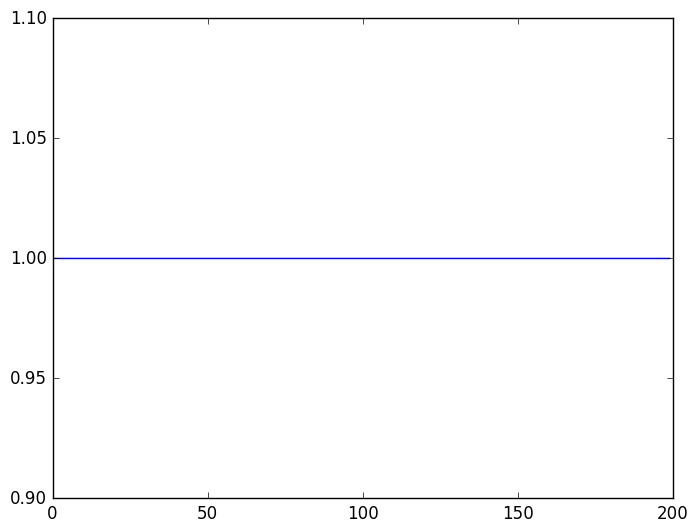

imag(ω) = 3.06200554101823e-13


(0.9,1.1)

In [4]:
Dt = passive_threshold!(laplacian!, pmd, las, (D, D*1.05))
ωt = real(pmd.ω)
println("imag(ω) = ", imag(pmd.ω))
plot(abs(pmd.E))
ylim(0.9, 1.1)

In [5]:
E₊ = copy(pmd.E)
E₋ = conj(E₊)
P(E) = Dt * γ⟂ / (ωt - ωa + 1im*γ⟂) * E
vk(E) = [real(E); imag(E); real(P(E)); imag(P(E)); zeros(E)]
V = cat((2,), vk(E₊), vk(E₋), vk(1im*E₊), vk(1im*E₋));

In [23]:
γpar = 2e-3
d = 0.0
D = Dt*(1+d)
csq = d
md = Mode(copy(pmd.E), ωt, csq)
solve!(laplacian!, md, las, D)

Λall, Xall = all_stability_pairs(laplacian!, 
       sqrt(md.c²) * md.E, md.ω, D, γpar, las.ɛ);

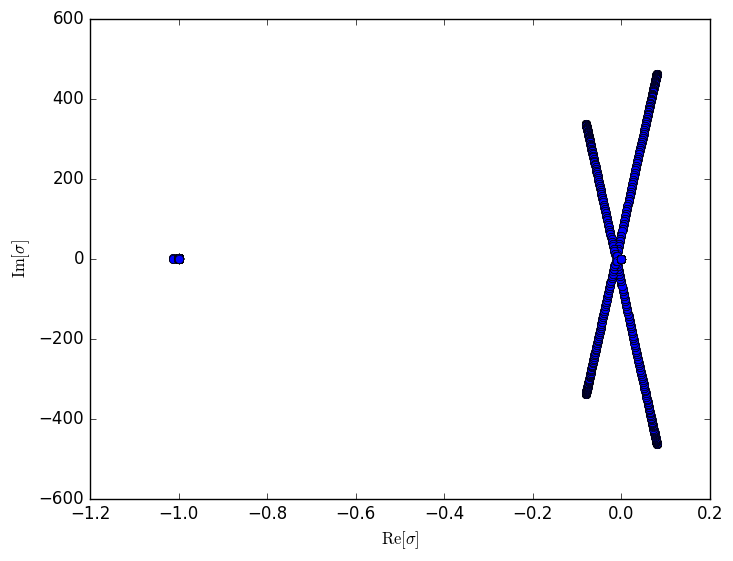

In [32]:
plot(real(Λall), imag(Λall), "o")
ylabel(L"\mathrm{Im}[\sigma]")
xlabel(L"\mathrm{Re}[\sigma]")
savefig("spectrum.png")

In [7]:
x0 = Xlow[:, 4]
bk = zeros(Complex{Float64}, 4)
for i in 1:4
    bk[i] = dot(V[:, i], x0) / norm(V[:, i])^2
end

# confirm that x0 is indeed sum bk vk
temp = 0im
for i in 1:4
    temp += bk[i] * V[:, i]
end
println("should be << 1: ", norm(temp - x0) / norm(x0))
println("note that intensity pattern is uniform, so any shift ",
"of the circulating modes work as x0, so it doesn't necessarily ",
"have to be [0, 0, 1, 0] for the first eigenvector")
println("\nif close to 1, then x0 is linear combination of vks only:\n", norm(bk))

should be << 1: 0.0021119908705586827
note that intensity pattern is uniform, so any shift of the circulating modes work as x0, so it doesn't necessarily have to be [0, 0, 1, 0] for the first eigenvector

if close to 1, then x0 is linear combination of vks only:
1.0010265770437818


|f| = 2.428542851333326e-5
|f| = 1.4091574096330987e-10


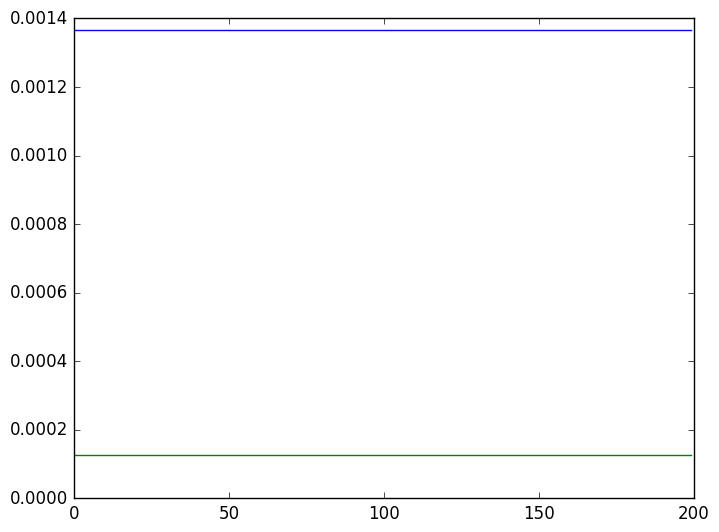

 76.194576 seconds (25.44 k allocations: 434.773 MB, 0.13% gc time)
there are unstable linearized MB eigenvalues:


4-element Array{Complex{Float64},1}:
        -2.45338e-10+0.0im      
         0.000717113+0.0163079im
         0.000717113-0.0163079im
 -0.0217495+4.16706e-5im        

In [9]:
# must start from the top because the positive unstable
# eigenvalue is not one of the four smallest at small d
d_orig = 10.0
D = Dt*(1+d_orig)
csq = d_orig
md = Mode(copy(pmd.E), ωt, csq)
solve!(laplacian!, md, las, D, isprint=true)
# note in the uniform ring that there cannot be more than one
# mode lasing, because the intensity of the first lasing mode
# is uniform, and the *effective* pump strength D = D0 / (1+c^2|E|^2)
# is always just Dt, so the passive poles of other modes are
# always stuck at their Dt values

plot(Dt * ones(md.E))
plot(Dt * (1+d_orig) ./ (1+md.c² * abs(md.E).^2))

@time Λ, X = smallest_stability_pairs(laplacian!, 
       sqrt(md.c²) * md.E, md.ω, D, γpar, las.ɛ);
println("there are unstable linearized MB eigenvalues:")
Λ

In [10]:
x0 = X[:, 4]
bk = zeros(Complex{Float64}, 4)
for i in 1:4
    bk[i] = dot(V[:, i], x0) / norm(V[:, i])^2
end

println("\nif closer to 0 than to 1, then x0 ",
"is linear combination of *other* passive modes:\n", norm(bk))


if closer to 0 than to 1, then x0 is linear combination of *other* passive modes:
2.2035981859543025e-8


In [11]:
function test()
    E₋ = conj(md.E)
    mdm = Mode(E₋, md.ω, md.c²)
    D = Dt*(1+d_orig)
    solve!(laplacian!, mdm, las, D, isprint=true)
end

# E₋ instantly solves SALT too
test()

|f| = 1.6861749492968113e-10


(1.6861749492968113e-10,0)

In [ ]:
function stability_eigenvalue(d, γpar, λ, x, Dt, las, laplacian!)
    C = C_matrix(las.ɛ) # technically can be outside function
    D = Dt*(1+d)
    Esalt = sqrt(md.)
    solve!(laplacian!, )
end

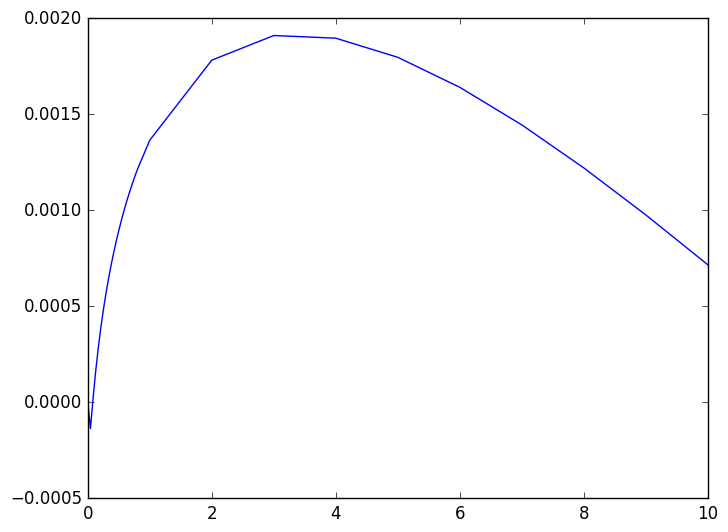

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x328cb9990>

In [14]:
meig = 2
λ = Λ[meig]
x = X[:, meig]
ds = [linspace(10, 1, 10); linspace(0.8, 0, 20)]
λs = zeros(Complex{Float64}, length(ds))
md2 = Mode(copy(md.E), md.ω, md.c²)
C = C_matrix(las.ɛ)
for (i, d) in enumerate(ds)
    D = Dt*(1+d)
    solve!(laplacian!, md2, las, D)
    Esalt = sqrt(md2.c²) * md2.E
    A = A_matrix(laplacian!, Esalt, md2.ω, las, D, γpar)
    B = B_matrix(las.ɛ, md2.ω)
    λ, x = quad_newton(A, B, C, λ, x)
    λs[i] = λ
end

plot(ds, real(λs))